In [ ]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    %pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    %pip install -q torch-geometric

     |████████████████████████████████| 48 kB 3.8 MB/s 
     |████████████████████████████████| 407 kB 14.1 MB/s 


In [ ]:
from typing import Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict

In [ ]:
dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
# For num. edges see:
# - https://github.com/pyg-team/pytorch_geometric/issues/343
# - https://github.com/pyg-team/pytorch_geometric/issues/852
num_edges = dataset.data.num_edges // 2
train_len = dataset[0].train_mask.sum()
val_len = dataset[0].val_mask.sum()
test_len = dataset[0].test_mask.sum()
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Dataset len.: {dataset.len()}")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1


Processing...
Done!


In [ ]:
dataset = Planetoid("/tmp/Cora", name="Cora")
print(f"Sum of row values without normalization: {dataset[0].x.sum(dim=-1)}")

dataset = Planetoid("/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
print(f"Sum of row values with normalization: {dataset[0].x.sum(dim=-1)}")

Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


In [ ]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        num_classes: int,
        hidden_dim: int = 16,
        dropout_rate: float = 0.5,
    ) -> None:
        super().__init__()
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x: Tensor, edge_index: Tensor) -> torch.Tensor:
        x = self.dropout1(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.conv2(x, edge_index)
        return x
print("Graph Convolutional Network (GCN):")
GCN(dataset.num_node_features, dataset.num_classes)

Graph Convolutional Network (GCN):


GCN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 7)
)

In [ ]:
LossFn = Callable[[Tensor, Tensor], Tensor]
Stage = Literal["train", "val", "test"]

def train_step(
    model: torch.nn.Module, data: Data, optimizer: torch.optim.Optimizer, loss_fn: LossFn
) -> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc

@torch.no_grad()
def eval_step(model: torch.nn.Module, data: Data, loss_fn: LossFn, stage: Stage) -> Tuple[float, float]:
    model.eval()
    mask = getattr(data, f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = loss_fn(logits, y)
    # + L2 regularization to the first layer only
    # for name, params in model.state_dict().items():
    #     if name.startswith("conv1"):
    #         loss += 5e-4 * params.square().sum() / 2.0

    acc = accuracy(preds, y)
    return loss.item(), acc

In [ ]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = True,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [ ]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)


Epoch: 0
----------
Train loss: 1.9452 | Train acc: 0.1286
  Val loss: 1.9455 |   Val acc: 0.0960

Epoch: 20
----------
Train loss: 1.7186 | Train acc: 0.6714
  Val loss: 1.8134 |   Val acc: 0.5060

Epoch: 40
----------
Train loss: 1.3818 | Train acc: 0.8214
  Val loss: 1.6027 |   Val acc: 0.6760

Epoch: 60
----------
Train loss: 1.0128 | Train acc: 0.8571
  Val loss: 1.3510 |   Val acc: 0.7580

Epoch: 80
----------
Train loss: 0.7533 | Train acc: 0.9143
  Val loss: 1.1628 |   Val acc: 0.7820

Epoch: 100
----------
Train loss: 0.6314 | Train acc: 0.9500
  Val loss: 1.0473 |   Val acc: 0.7820

Epoch: 120
----------
Train loss: 0.5400 | Train acc: 0.9286
  Val loss: 0.9642 |   Val acc: 0.7800

Epoch: 140
----------
Train loss: 0.5068 | Train acc: 0.9214
  Val loss: 0.9254 |   Val acc: 0.7800

Early stopping...

Epoch: 141
----------
Train loss: 0.5412 | Train acc: 0.9286
  Val loss: 0.9303 |   Val acc: 0.7740
 Test loss: 0.9081 |  Test acc: 0.7960


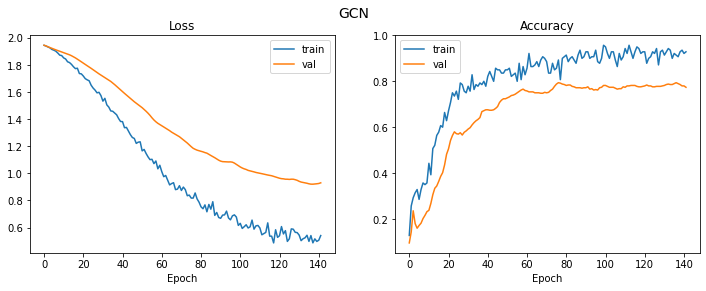

In [ ]:
plt.figure(figsize=(12, 4))
plot_history(history, "GCN")

In [ ]:
########################################### PART 2 ##################################

Sum of row values without normalization: tensor([ 9., 23., 19.,  ..., 18., 14., 13.])
Sum of row values with normalization: tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])


In [ ]:
LR=0.001
HC=8
NC=3
from torch_geometric.nn import SAGEConv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device, 'x', 'y')
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for i in range(NC-2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
            if i < len(self.convs) - 1 and i>0:
                x = conv(x, edge_index)
                x = x.relu_()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        print("testtest")
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
            if i < len(self.convs) - 1 and i>0:
                xs = []
                for batch in subgraph_loader:
                    x = x_all[batch.n_id.to(x_all.device)].to(device)
                    x = conv(x, batch.edge_index.to(device))
                    x = x.relu_()
                    xs.append(x[:batch.batch_size].cpu())
                x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all
    
model = SAGE(dataset.num_features, HC, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples
@torch.no_grad()
def test():
    model.eval()
    y_hat = model.inference(data.x, subgraph_loader).argmax(dim=-1)
    y = data.y.to(y_hat.device)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_hat[mask] == y[mask]).sum()) / int(mask.sum()))
    return accs

In [ ]:
#print(torch.cuda.memory_summary())

In [ ]:
BS=2048
kwargs = {'batch_size': BS, 'num_workers': 6, 'persistent_workers': True}
import copy
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[25, 10], shuffle=True, **kwargs)
subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)
# Already send node features/labels to GPU for faster access during sampling:

for epoch in range(1, 50):
    loss, acc = train(epoch)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
train_acc, val_acc, test_acc = test()
print(f'Epoch: {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
      f'Test: {test_acc:.4f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

Epoch 01: 100%|██████████| 140/140 [00:00<00:00, 676.04it/s]


Epoch 01, Loss: 1.9267, Approx. Train: 0.1929



Epoch 02: 100%|██████████| 140/140 [00:00<00:00, 1932.46it/s]


Epoch 02, Loss: 1.9018, Approx. Train: 0.1786



Epoch 03: 100%|██████████| 140/140 [00:00<00:00, 2532.52it/s]


Epoch 03, Loss: 1.9404, Approx. Train: 0.1643



Epoch 04: 100%|██████████| 140/140 [00:00<00:00, 2577.03it/s]


Epoch 04, Loss: 1.9162, Approx. Train: 0.2429



Epoch 05: 100%|██████████| 140/140 [00:00<00:00, 2409.00it/s]


Epoch 05, Loss: 1.9200, Approx. Train: 0.2000



Epoch 06: 100%|██████████| 140/140 [00:00<00:00, 2894.06it/s]


Epoch 06, Loss: 1.9051, Approx. Train: 0.2286



Epoch 07: 100%|██████████| 140/140 [00:00<00:00, 2709.67it/s]


Epoch 07, Loss: 1.9340, Approx. Train: 0.1786



Epoch 08: 100%|██████████| 140/140 [00:00<00:00, 2857.84it/s]


Epoch 08, Loss: 1.9091, Approx. Train: 0.2143



Epoch 09: 100%|██████████| 140/140 [00:00<00:00, 2678.68it/s]


Epoch 09, Loss: 1.9181, Approx. Train: 0.1786



Epoch 10: 100%|██████████| 140/140 [00:00<00:00, 2135.92it/s]


Epoch 10, Loss: 1.9219, Approx. Train: 0.1714



Epoch 11: 100%|██████████| 140/140 [00:00<00:00, 1966.79it/s]


Epoch 11, Loss: 1.9355, Approx. Train: 0.1500



Epoch 12: 100%|██████████| 140/140 [00:00<00:00, 2469.49it/s]


Epoch 12, Loss: 1.9166, Approx. Train: 0.2143



Epoch 13: 100%|██████████| 140/140 [00:00<00:00, 2459.38it/s]


Epoch 13, Loss: 1.9205, Approx. Train: 0.2143



Epoch 14: 100%|██████████| 140/140 [00:00<00:00, 2101.81it/s]


Epoch 14, Loss: 1.9040, Approx. Train: 0.2143



Epoch 15: 100%|██████████| 140/140 [00:00<00:00, 2544.22it/s]


Epoch 15, Loss: 1.9088, Approx. Train: 0.2214



Epoch 16: 100%|██████████| 140/140 [00:00<00:00, 2521.45it/s]


Epoch 16, Loss: 1.9172, Approx. Train: 0.2000



Epoch 17: 100%|██████████| 140/140 [00:00<00:00, 2795.39it/s]


Epoch 17, Loss: 1.9179, Approx. Train: 0.1857



Epoch 18: 100%|██████████| 140/140 [00:00<00:00, 2833.21it/s]


Epoch 18, Loss: 1.8929, Approx. Train: 0.2071



Epoch 19: 100%|██████████| 140/140 [00:00<00:00, 2895.78it/s]


Epoch 19, Loss: 1.8999, Approx. Train: 0.2214



Epoch 20: 100%|██████████| 140/140 [00:00<00:00, 2959.41it/s]


Epoch 20, Loss: 1.9071, Approx. Train: 0.2286



Epoch 21: 100%|██████████| 140/140 [00:00<00:00, 2351.42it/s]


Epoch 21, Loss: 1.8975, Approx. Train: 0.2286



Epoch 22: 100%|██████████| 140/140 [00:00<00:00, 2683.56it/s]


Epoch 22, Loss: 1.9044, Approx. Train: 0.1929



Epoch 23: 100%|██████████| 140/140 [00:00<00:00, 2281.82it/s]


Epoch 23, Loss: 1.9100, Approx. Train: 0.2643



Epoch 24: 100%|██████████| 140/140 [00:00<00:00, 2611.05it/s]


Epoch 24, Loss: 1.8990, Approx. Train: 0.2000



Epoch 25: 100%|██████████| 140/140 [00:00<00:00, 2744.55it/s]


Epoch 25, Loss: 1.8936, Approx. Train: 0.2000



Epoch 26: 100%|██████████| 140/140 [00:00<00:00, 2583.81it/s]


Epoch 26, Loss: 1.8883, Approx. Train: 0.2357



Epoch 27: 100%|██████████| 140/140 [00:00<00:00, 2783.85it/s]


Epoch 27, Loss: 1.8677, Approx. Train: 0.2786



Epoch 28: 100%|██████████| 140/140 [00:00<00:00, 2674.51it/s]


Epoch 28, Loss: 1.8769, Approx. Train: 0.2214



Epoch 29: 100%|██████████| 140/140 [00:00<00:00, 2740.90it/s]


Epoch 29, Loss: 1.8622, Approx. Train: 0.2643



Epoch 30: 100%|██████████| 140/140 [00:00<00:00, 2493.15it/s]


Epoch 30, Loss: 1.9017, Approx. Train: 0.2071



Epoch 31: 100%|██████████| 140/140 [00:00<00:00, 2667.91it/s]


Epoch 31, Loss: 1.8572, Approx. Train: 0.3000



Epoch 32: 100%|██████████| 140/140 [00:00<00:00, 2826.04it/s]


Epoch 32, Loss: 1.8780, Approx. Train: 0.2286



Epoch 33: 100%|██████████| 140/140 [00:00<00:00, 2532.46it/s]


Epoch 33, Loss: 1.8720, Approx. Train: 0.2929



Epoch 34: 100%|██████████| 140/140 [00:00<00:00, 2721.97it/s]


Epoch 34, Loss: 1.8828, Approx. Train: 0.2357



Epoch 35: 100%|██████████| 140/140 [00:00<00:00, 2638.71it/s]


Epoch 35, Loss: 1.8861, Approx. Train: 0.2286



Epoch 36: 100%|██████████| 140/140 [00:00<00:00, 2653.76it/s]


Epoch 36, Loss: 1.8731, Approx. Train: 0.2000



Epoch 37: 100%|██████████| 140/140 [00:00<00:00, 2639.43it/s]


Epoch 37, Loss: 1.8804, Approx. Train: 0.2000



Epoch 38: 100%|██████████| 140/140 [00:00<00:00, 2403.06it/s]


Epoch 38, Loss: 1.8693, Approx. Train: 0.2786



Epoch 39: 100%|██████████| 140/140 [00:00<00:00, 2321.81it/s]


Epoch 39, Loss: 1.8668, Approx. Train: 0.2286



Epoch 40: 100%|██████████| 140/140 [00:00<00:00, 2455.48it/s]


Epoch 40, Loss: 1.8823, Approx. Train: 0.2500



Epoch 41: 100%|██████████| 140/140 [00:00<00:00, 2054.24it/s]


Epoch 41, Loss: 1.8543, Approx. Train: 0.2929



Epoch 42: 100%|██████████| 140/140 [00:00<00:00, 2818.12it/s]


Epoch 42, Loss: 1.8801, Approx. Train: 0.1786



Epoch 43: 100%|██████████| 140/140 [00:00<00:00, 2526.49it/s]


Epoch 43, Loss: 1.8676, Approx. Train: 0.2286



Epoch 44: 100%|██████████| 140/140 [00:00<00:00, 2033.24it/s]


Epoch 44, Loss: 1.8743, Approx. Train: 0.2357



Epoch 45: 100%|██████████| 140/140 [00:00<00:00, 2462.76it/s]


Epoch 45, Loss: 1.8576, Approx. Train: 0.2286



Epoch 46: 100%|██████████| 140/140 [00:00<00:00, 2668.22it/s]


Epoch 46, Loss: 1.8677, Approx. Train: 0.2571



Epoch 47: 100%|██████████| 140/140 [00:00<00:00, 2540.95it/s]


Epoch 47, Loss: 1.8647, Approx. Train: 0.2286



Epoch 48: 100%|██████████| 140/140 [00:00<00:00, 2640.39it/s]


Epoch 48, Loss: 1.8557, Approx. Train: 0.2143



Epoch 49: 100%|██████████| 140/140 [00:00<00:00, 2725.70it/s]


Epoch 49, Loss: 1.8276, Approx. Train: 0.2786
testtest



Evaluating: 100%|██████████| 8124/8124 [00:00<00:00, 24471.48it/s]

Epoch: 49, Train: 0.3143, Val: 0.2480, Test: 0.2370


In [ ]:
for i, conv in enumerate(model.convs):
    print(conv)

SAGEConv(1433, 8)
SAGEConv(8, 8)
SAGEConv(8, 7)
